# Density-Matrix Decoherence Demo

This notebook extends the wave-function workflow to open quantum systems. We evolve a driven-less qubit under amplitude damping using both the Lindblad master equation and quantum trajectories, and then fold in a detector model that mixes in inefficiencies and dark counts.

## 1. Imports and helpers

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from wavefunction_now.lindblad import LindbladSimulator, QuantumTrajectorySimulator
from wavefunction_now.measurement import density_matrix_probabilities, apply_detector_response

plt.style.use('ggplot')

## 2. Lindblad evolution of an amplitude-damped qubit

We initialise the qubit in the excited state and evolve it under a single collapse operator \(\sqrt{\gamma} \sigma_-\). The analytical excited-state population is \($e^{-\gamma t}$\), so we can check that the master-equation solver reproduces this curve.

In [2]:
gamma = 0.35
sigma_minus = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=complex)
collapse_ops = (np.sqrt(gamma) * sigma_minus,)
hamiltonian = np.zeros((2, 2), dtype=complex)

lindblad = LindbladSimulator(hamiltonian, collapse_ops)
times = np.linspace(0.0, 1.2, 121)
rho0 = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=complex)

rho_evolution = lindblad.evolve(rho0, times)
excited_pop = np.real(rho_evolution[:, 1, 1])
ground_pop = np.real(rho_evolution[:, 0, 0])

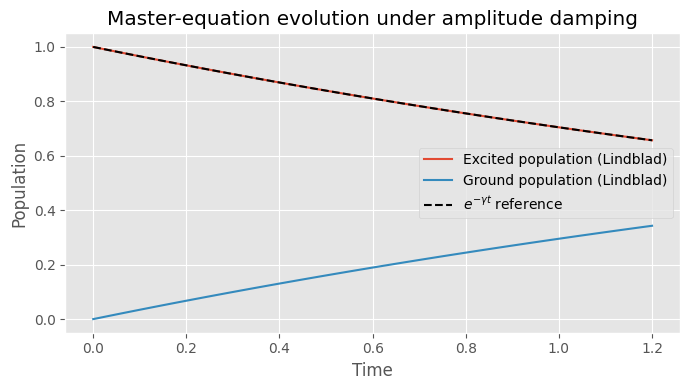

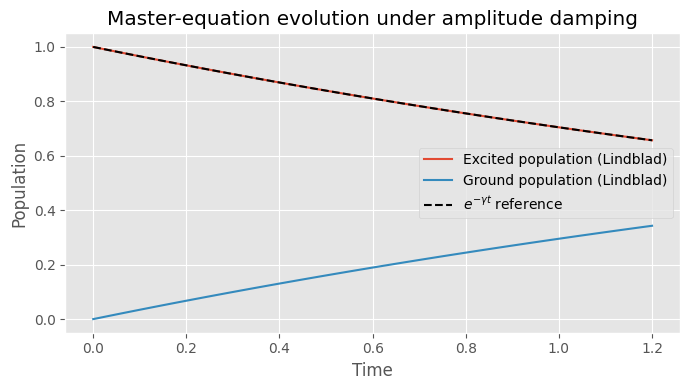

In [3]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(times, excited_pop, label='Excited population (Lindblad)')
ax.plot(times, ground_pop, label='Ground population (Lindblad)')
ax.plot(times, np.exp(-gamma * times), '--', color='black', label=r'$e^{-\gamma t}$ reference')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_title('Master-equation evolution under amplitude damping')
ax.legend()
fig.tight_layout()
fig

The Lindblad solver preserves trace and follows the expected exponential decay. In the next step we unravel the same dynamics into individual quantum jump trajectories.

## 3. Quantum-trajectory ensemble

Each trajectory generates a random history of jumps; averaging them should coincide with the Lindblad density matrix. We sample a few hundred trajectories to keep runtime modest while still seeing the agreement.

In [4]:
trajectory_sim = QuantumTrajectorySimulator(hamiltonian, collapse_ops)
psi0 = np.array([0.0, 1.0], dtype=complex)

ensemble = trajectory_sim.ensemble_density_matrix(
    psi0,
    times,
    trajectories=400,
    rng=np.random.default_rng(123),
)

ensemble_excited = np.real(ensemble[:, 1, 1])

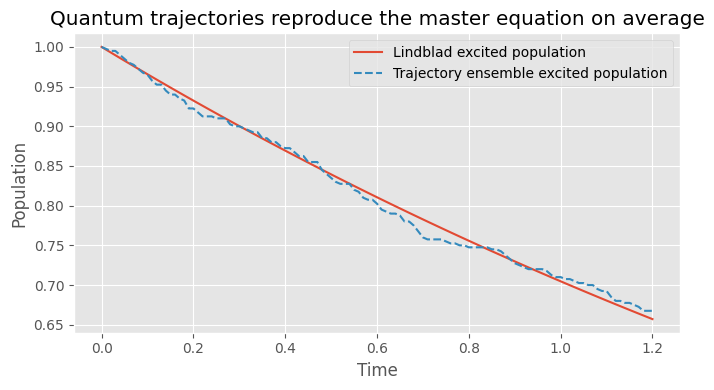

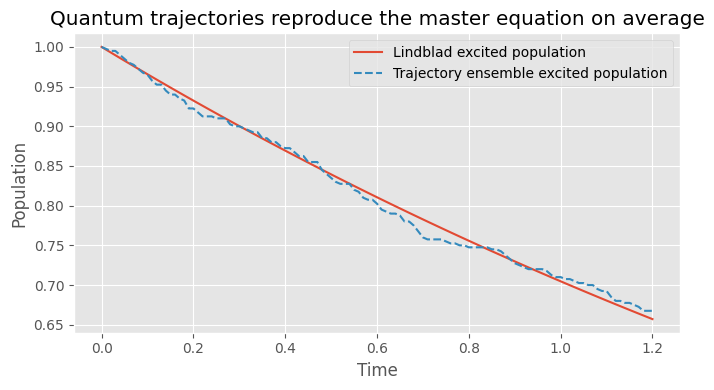

In [5]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(times, excited_pop, label='Lindblad excited population')
ax.plot(times, ensemble_excited, '--', label='Trajectory ensemble excited population')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.set_title('Quantum trajectories reproduce the master equation on average')
ax.legend()
fig.tight_layout()
fig

The stochastic trajectories fluctuate shot-to-shot, but the averaged density matrix matches the deterministic master equation within Monte Carlo noise.

## 4. Detector response: inefficiency and dark counts

Real detectors miss events and occasionally click spuriously. We fold those effects into the predicted outcomes for a $\sigma_z$ measurement.

In [6]:
# Projective effects for measuring |0> (ground) and |1> (excited)
effects = np.array([
    np.diag([1.0, 0.0]),
    np.diag([0.0, 1.0]),
])

ideal_probabilities = density_matrix_probabilities(rho_evolution[-1], effects)
adjusted_probabilities = apply_detector_response(
    ideal_probabilities,
    efficiency=0.85,
    dark_count=0.15,
    background=np.array([0.2, 0.8]),
)

print('Ideal measurement probabilities:', ideal_probabilities)
print('Detector-adjusted probabilities:', adjusted_probabilities)

Ideal measurement probabilities: [0.34295318 0.65704682]
Detector-adjusted probabilities: [0.3215102 0.6784898]


The detector model mixes a configurable background into the true signal and renormalises over the recorded clicks. You can sweep the efficiency or dark-count rate to explore different hardware limits.